In [46]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model, preprocessing
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display
import warnings
import seaborn as sns
import grab_data as grab_data

In [47]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files])
df_imported.index = pd.DatetimeIndex(df_imported.index, freq='H')
grouped = df_imported.groupby(level=0)
df_imported = grouped.last()
df_imported.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2016-05-17 20:00:00 to 2016-05-31 19:00:00
Freq: H
Data columns (total 25 columns):
$                           336 non-null int64
dateStamp                   56 non-null object
dew_point                   336 non-null float64
modelCode                   56 non-null object
modelRun                    56 non-null float64
periodSchedule              56 non-null float64
pressure                    336 non-null int64
screen_relative_humidity    336 non-null float64
sea_temperature             336 non-null float64
surf_max                    56 non-null float64
surf_min                    56 non-null float64
swell_direction1            56 non-null float64
swell_direction2            56 non-null float64
swell_direction3            56 non-null float64
swell_height1               56 non-null float64
swell_height2               56 non-null float64
swell_height3               56 non-null float64
swell_period1               56 non-

# Helper Functions

In [48]:
def plot_datetime_series(series, title = '', xlabel='Time', ylabel='Average Wave Height in m', label=['-', '-', '-', '-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        if type(s.index) is not pd.tseries.index.DatetimeIndex:
            dates = matplotlib.dates.date2num([dateutil.parser.parse(dt) for dt in s.index])
        else:
            dates = s.index
        plt.plot_date(
            dates,
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()

def plot_scatter_correlation(df, target):
    ncols = 3
    nrows = math.ceil(len(df.columns)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,3.5*nrows))
    for i,variable in enumerate(df.columns):
        row = 0
        col = i
        if i > 2:
            row = 1
            col = i - 3
        correlation = df[variable].corr(target)
        title = "corr = {:.5f}".format(correlation)    #variable + ': ' + "{:.5f}".format(correlation)      
        sns.regplot(df[variable], target, ax=axes[row][col])#, 'o')
        axes[row][col].set_title(title)
        #df.plot.scatter(x=variable, y=target_var, marker='+', ax=axes[row,col], title=title)
    unused_axes = ncols * nrows - len(df.columns) 
    for i in range(1, unused_axes+1):
        fig.delaxes(axes[-1][-i])

available target values: 56


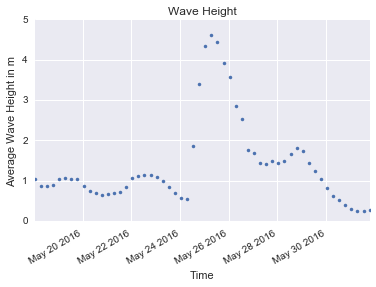

target values after interpolation: 331


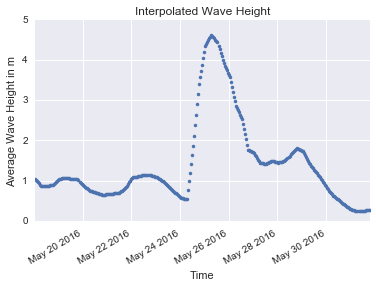

In [49]:
target_var = 'surf_avg'
s_target = pd.Series( ((df_imported['surf_max'] + df_imported['surf_min']) / 2)*0.3048, name=target_var )
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', '.')
# fill NAs with linearly interpolated data where explanatory data is present
s_target = s_target.loc[df_imported['wind_speed'].notnull()].interpolate()
#---respective data removed---- there's a big gap which we shouldn't interpolate
#s_target['2016-05-16 14:00:00':'2016-05-18 00:00:00'] = None
#-- uncomment to remove some outliers
#s_target = s_target[:'May 24 2016, 1am']
print('target values after interpolation:', s_target.count())  
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', '.')

# Drop Irrelevant Variables
Because these variables have no predictive power from logical and visual judgement, they are discarded at this point.

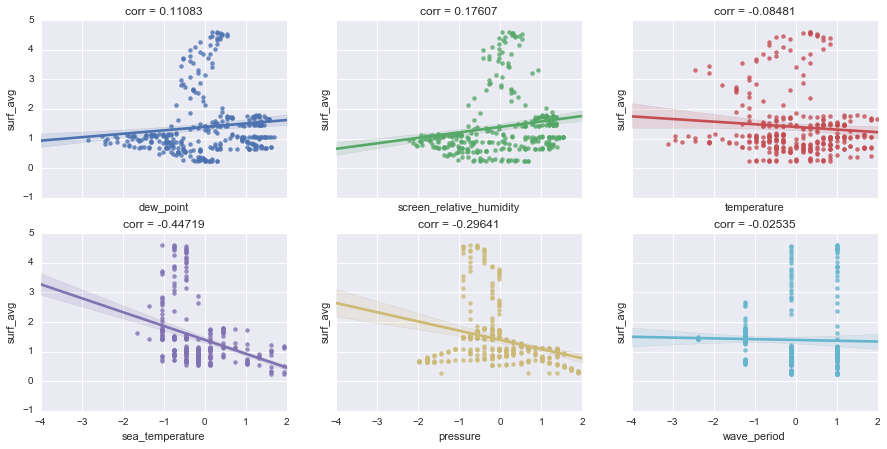

In [50]:
# sorted out at this point: 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature', 'pressure', 'wave_period'
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_scatter_correlation(
        df_imported[['dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature', 'pressure', 'wave_period']].dropna().apply(preprocessing.scale),
        s_target
    )
    
def drop_unused_variables(df_in):
    return df_in[['wind_direction', 'wind_speed', 'wave_height']]

df_explanatory = drop_unused_variables(df_imported)

In [51]:
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    #print(df_radians.columns)
    #def sine(series):
    #    pd.Series(series.apply(math.sin)
    df_sin = df_radians.apply(lambda series: series.map(math.sin))
    df_cos = df_radians.apply(lambda series: series.map(math.cos))
    df_sin.columns = [col + '-Sin' for col in df_sin.columns]
    df_cos.columns = [col + '-Cos' for col in df_cos.columns]
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            df_sin,
            df_cos
            #directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees-Sin,degrees-Cos
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


In [52]:
df_explanatory = df_explanatory.dropna()
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
def transform_wind_direction(df_in):
    df_out = df_in.copy()
    df_out['wind_direction'] = df_out['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
    df_out = degrees_to_sin_cos(df_out, 'wind_direction')
    return df_out
display(df_explanatory[['wind_direction']].head())
print('becomes')
display(pd.DataFrame(df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))).head())
print('becomes')
df_explanatory = transform_wind_direction(df_explanatory)
display(df_explanatory[['wind_direction-Sin','wind_direction-Cos']].head())

,wind_direction
2016-05-17 20:00:00,WSW
2016-05-17 21:00:00,WSW
2016-05-17 22:00:00,WSW
2016-05-17 23:00:00,W
2016-05-18 00:00:00,W


becomes


,wind_direction
2016-05-17 20:00:00,247.5
2016-05-17 21:00:00,247.5
2016-05-17 22:00:00,247.5
2016-05-17 23:00:00,270.0
2016-05-18 00:00:00,270.0


becomes


,wind_direction-Sin,wind_direction-Cos
2016-05-17 20:00:00,-0.92388,-3.826834e-01
2016-05-17 21:00:00,-0.92388,-3.826834e-01
2016-05-17 22:00:00,-0.92388,-3.826834e-01
2016-05-17 23:00:00,-1.00000,-1.836970e-16
2016-05-18 00:00:00,-1.00000,-1.836970e-16


In [53]:
print('Data types of columns')
pd.DataFrame({'column':df_explanatory.columns},[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,column
int64,wind_speed
float64,wave_height
float64,wind_direction-Sin
float64,wind_direction-Cos


In [54]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_speed            331
wave_height           331
wind_direction-Sin    331
wind_direction-Cos    331
surf_avg              331
dtype: int64

# Normalization

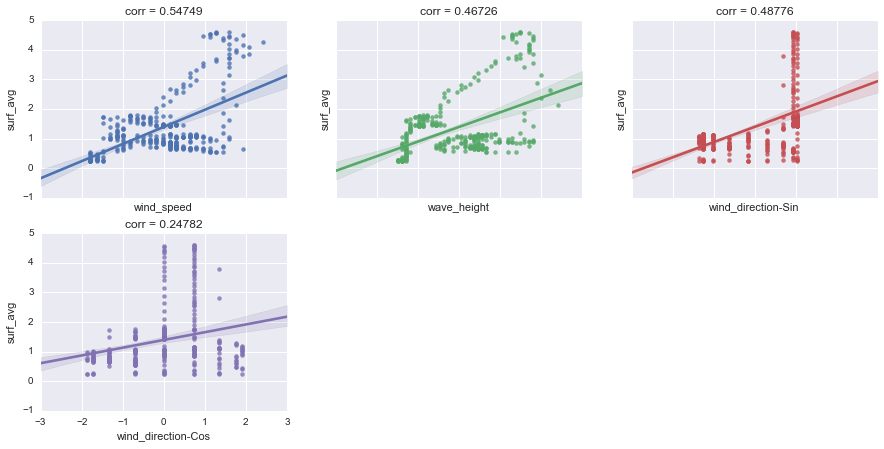

In [55]:
#mean_target = s_target.mean()
#std_target = s_target.std()
#def denormalize_target(series):
#    return series * std_target + mean_target

def normalize(df_in):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return df_in.apply(preprocessing.scale)

df_train[df_explanatory.columns] = normalize(df_train[df_explanatory.columns])
plot_scatter_correlation(df_train[df_explanatory.columns], df_train[target_var])
#df_train = df_train.apply(preprocessing.scale)

# Determining the Lag
In order to find out the lag between target variable and each of the explanatory variables, a cross correlation for all lags between 0 and 40 is computed. Afterwards, the correlation of the best fitting lags is looked at more closely.

,wind_speed,wave_height,wind_direction-Sin,wind_direction-Cos,surf_avg
2016-05-18 01:00:00,1.600752,0.766359,-1.264521,0.735446,1.040892
2016-05-18 02:00:00,1.115246,1.280684,-1.355368,0.011582,1.012698
2016-05-18 03:00:00,1.115246,1.177819,-1.264521,0.735446,0.984504
2016-05-18 04:00:00,1.277081,1.795008,-1.264521,0.735446,0.956310
2016-05-18 05:00:00,1.115246,1.692143,-1.264521,0.735446,0.928116


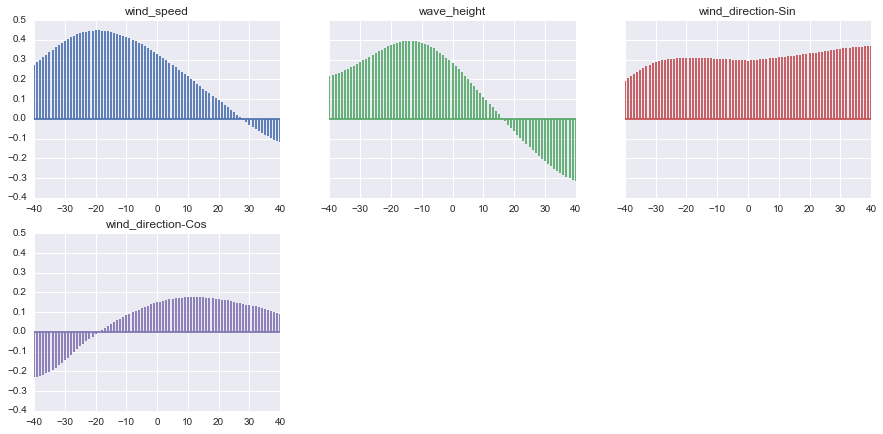

In [56]:
display(df_train.head())
lag_corr = list()
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15,7))
for i,var in enumerate(df_explanatory.columns):
    row = 0
    col = i
    if i > 2:
        row = 1
        col = i - 3
    _, vec, _, _ = axes[row][col].xcorr(df_train[var], df_train[target_var], maxlags=40, color=sns.color_palette()[i])
    lag_corr.append(vec)
    axes[row][col].set_title(var)
fig.delaxes(axes[1,2])
fig.delaxes(axes[1,1])

The highest correlation seems to be at a lag of about -5 to -15, but is different for each variable. 
- Wind speed appears to have a very high lag, just like the wind direction.
- Wave height and wave period both have a smaller lag.

optimal lags are [-20.0, -15.0, 39.0, 11.0] (maximum lag is set to -5 )
complete training rows left after lagging: 311 (lost: 20 )


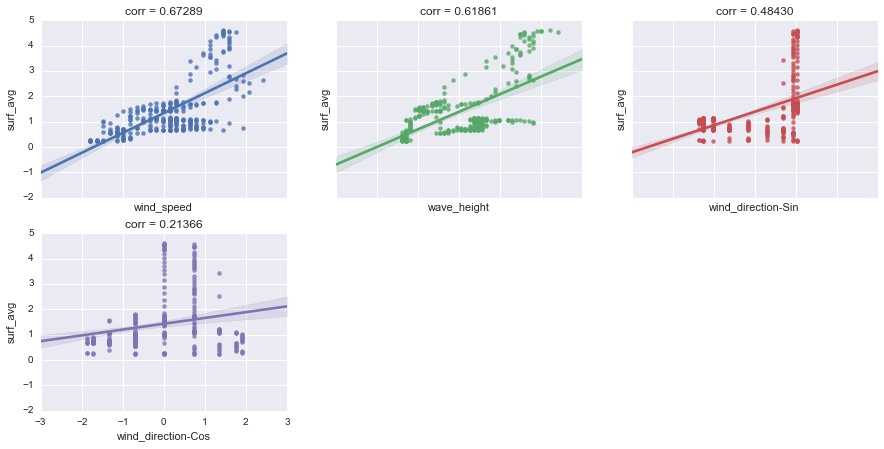

In [57]:
optimal_lags = [list(vec).index(vec.max()) - (len(vec)+1)/2 for vec in lag_corr]
max_lag = -5 # should be negative or 0!
print('optimal lags are', optimal_lags, '(maximum lag is set to',max_lag,')')
def lag(df_in):
    df_lagged = pd.DataFrame()
    for i, lag in enumerate(optimal_lags):
        var = df_in.columns[i]
        if(lag > max_lag):
            lag = max_lag
        df_lagged = pd.concat([df_lagged,df_in[var].shift(-lag, freq='H', axis=0)], axis=1)
    return df_lagged
df_lagged = pd.concat([lag(df_train[df_explanatory.columns]),df_train[target_var]], axis=1).dropna()
print('complete training rows left after lagging:', len(df_lagged), '(lost:', len(df_train)-len(df_lagged), ')')

plot_scatter_correlation(df_lagged[df_explanatory.columns], df_lagged[target_var])

In [58]:
#lag_compare = pd.DataFrame(
#    {'unlagged': [df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns]},
#    index = df_explanatory.columns
#)
#for lag in range(5,16, 3):
#    lag_compare['lag '+str(lag)] = [df_train[target_var].shift(-lag).corr(df_train[column]) for column in df_explanatory.columns] 
#lag_compare.plot()

#df_lagged = df_train.copy()
#df_lagged[target_var] = df_lagged[target_var].shift(-10)
#plot_scatter_correlation(df_lagged[df_explanatory.columns], df_lagged[target_var])

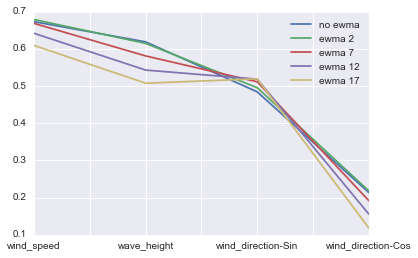

In [59]:
corr_with_target = pd.DataFrame(
    {'no ewma': [df_lagged[column].corr(df_lagged[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,20, 5):
    corr_with_target['ewma '+str(span)] = pd.Series([ pd.ewma(df_lagged[column], span=span).corr(df_lagged[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
corr_with_target.plot()
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

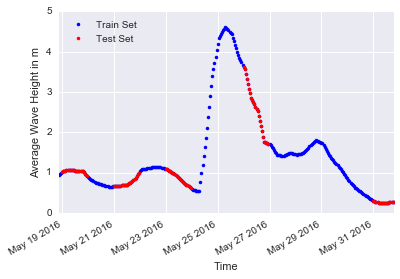

In [60]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

def split_dataset_day_sensitive(df_in, percent_test):
    days = pd.Series(df_in.index).map(pd.Timestamp.date).unique()
    total_size = len(days)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ str(days[randint]) for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.concat([df_train[l] for l in record_labels], axis=0)
    for l in record_labels:
        df_train.drop(df_train[l].index)
    return df_train, df_test

train_set, test_set = split_dataset_day_sensitive(df_lagged, 0.4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'])

coefficients:  [ 0.06623351  0.7851763   0.55530369  0.22415946]


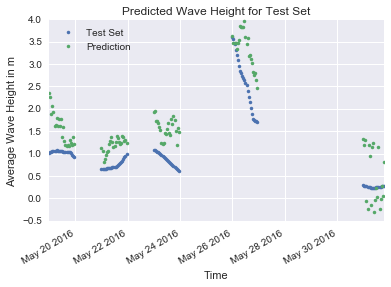

In [61]:
# perform prediction data assuming 0 lag
regr = linear_model.LinearRegression()
train_set, train_set = split_dataset_day_sensitive(df_train, 0.4)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([
        test_set[target_var], 
        predictions
    ], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m', ['.', '.'])

coefficients:  [ 0.12804048  0.75600989  0.64325866  0.20875057]
intercept:  1.3350785465


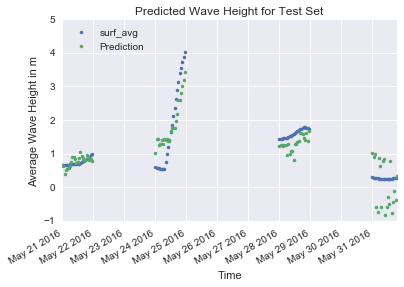

In [62]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
#df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset_day_sensitive(df_lagged.dropna(), 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m', ['.','.'])

fully_trained_regression = linear_model.LinearRegression()
fully_trained_regression.fit(df_lagged[df_explanatory.columns].as_matrix(), df_lagged[target_var].as_matrix())
def make_prediction(df_in):
    return pd.Series(fully_trained_regression.predict(df_in.as_matrix()), name='Prediction', index=df_in.index)

In [63]:
df_lagged.head()
lm = sm.OLS(df_lagged[target_var], df_lagged[df_explanatory.columns]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     48.82
Date:                Tue, 31 May 2016   Prob (F-statistic):           9.21e-32
Time:                        21:37:05   Log-Likelihood:                -545.55
No. Observations:                 311   AIC:                             1099.
Df Residuals:                     307   BIC:                             1114.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
wind_speed             0.4531      0.163      2.778      0.006         0.132     0.774
wave_height            0.5676      0.162      3.504      0.001         0.249     0.886
wind_direction-Sin     0.7047      0.089      7.910      0.000         0.529     0.880
wind_direction-Cos     0.1495      0.081      1.841      0.067        -0.010     0.309
==============================================================================
Omnibus:                        5.310   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                5.526
Skew:                          -0.215   Prob(JB):                       0.0631
Kurtosis:                       3.492   Cond. No.                         3.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R² value indicates the percentage of variance in the data which are explained by the model. This is a good fit, but also may indicate overfit.

In [64]:
print('p value >= 0.05')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.05')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.05
wind_direction-Cos    0.066531
dtype: float64

p value < 0.05
wind_speed            5.804318e-03
wave_height           5.258105e-04
wind_direction-Sin    4.706843e-14
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.

# Make a Real Prediction

In [65]:
if 'live_target' not in vars():
    live_target = grab_data.target(5)
if 'live_explanatory' not in vars():
    live_explanatory = grab_data.explanatory()

In [66]:
def preprocess(df_in):
    df_out = df_in.copy()
    preprocessing_functions = [
        'drop_unused_variables',
        'transform_wind_direction',
        'normalize',
        'lag'
    ]
    for fn in preprocessing_functions:
        df_out = globals()[fn](df_out)
    return df_out.dropna()
#def predict(df_in):
    

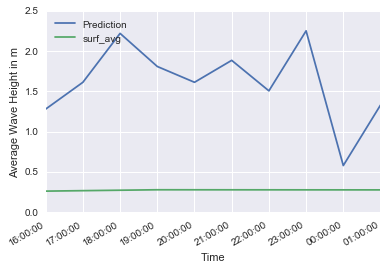

In [67]:
preprocessed = preprocess(live_explanatory)
predictions = make_prediction(preprocessed)
#predictions = pd.Series(predictions, index=preprocessed.index)
plot_datetime_series([predictions, live_target[predictions.index]])